# Part 2. Heston vs Local Volatility

- Compare Vanilla Options for different strike and maturities. 
- Compare other contracts - Forwars options, Collars, Forward Collars, Cliquets. 

Start with the imports.

In [ ]:
import numpy as np
import pandas as pd
import pyarrow as pa
from datetime import datetime
from matplotlib import pyplot as plt


# contracts
from qablet_contracts.timetable import py_to_ts, TS_EVENT_SCHEMA
from qablet_contracts.eq.vanilla import Option
from qablet_contracts.eq.forward import ForwardOption
from qablet_contracts.eq.cliquet import Accumulator

# models
from qablet.heston.mc import HestonMCModel
from qablet.black_scholes.mc import LVMCModel

## Common Dataset

In [ ]:
# Market Data
ticker = "SPX"
rate = 0.00  # 0.03
div = 0.00  # 0.01
spot = 100
pricing_dt = datetime(2023, 12, 31)

# flat array for discounts and forwards
tmax = 2.0
times = np.array([0.0, tmax])
rates = np.array([rate, rate])
fwds = spot * np.exp((rate - div) * times)

usd_crv = ("ZERO_RATES", np.column_stack((times, rates)))
fwds_crv = ("FORWARDS", np.column_stack((times, fwds)))
fwds_crv

('FORWARDS',
 array([[  0., 100.],
        [  2., 100.]]))

In [ ]:
# complete common dataset
dataset = {
    "BASE": "USD",
    "PRICING_TS": py_to_ts(pricing_dt).value,
    "ASSETS": {
        "USD": usd_crv,
        ticker: fwds_crv,
    },
    "MC": {
        "PATHS": 50_000,
        "TIMESTEP": 1 / 100,
        "SEED": 1,
    },
}

# Heston Model and Parameters
Similar to the previous Notebook.

In [ ]:
heston_model = HestonMCModel()

heston_dataset = dataset.copy()
heston_dataset["HESTON"] = {
    "ASSET": ticker,
    "INITIAL_VAR": 0.04,
    "LONG_VAR": 0.04,
    "MEANREV": 10,
    "VOL_OF_VAR": 1,
    "CORRELATION": -1.0,
}

##  Local Volatility Model
We will use a Local Volatility function that generates a surface that similar to the choice of Heston Parameters above. The derivation of such an approximation function for the local variance is given in "The Volatility Surface", *Chapter 4.1. Local Variance in The Heston Nandi Model.*

Modified Mean Reversion ($\lambda$) and long variance ($v$)

$$
\lambda^{'} = \lambda + \eta / 2 \\

\bar{v}^{'} = \bar{v} \cdot  \lambda / \lambda^{'}
$$

Then define the local vol function s below.

$$
\begin{aligned}
v^{atm}_{loc}(t) &= (v-\bar{v}^{'} ) \cdot e^{-\lambda^{'} t} + \bar{v}^{'}  \\

v^{skew}_{loc}(t) &=  - \eta \left\{ \frac{1 - e^{-\lambda^{'} t}}{\lambda^{'} T} \right\} \\

v_{loc}(x_t, t) &= v^{atm}_{loc}(t)  + x_t \cdot v^{skew}_{loc}(t)
\end{aligned}
$$


In [ ]:
lm = heston_dataset["HESTON"]["MEANREV"]
eta = heston_dataset["HESTON"]["VOL_OF_VAR"]
vl = heston_dataset["HESTON"]["LONG_VAR"]
vi = heston_dataset["HESTON"]["INITIAL_VAR"]

_lm = lm + eta / 2
_vl = vl * lm / _lm


# local vol function, takes a tuple of current time and log-spot vector
def local_vol(points):
    (t, x_vec) = points

    atm = (vi - _vl) * np.exp(-_lm * t) + _vl
    if t < 1e-6:
        shape = -eta  # special case for t=0 so that denom doesn't blow up
    else:
        shape = -eta * (1 - np.exp(-_lm * t)) / (_lm * t)

    out = x_vec * shape
    np.add(out, atm, out=out)
    # floor it, because the approximation works less well away from atm and can be negative
    np.maximum(0.001, out, out=out)
    np.sqrt(out, out=out)
    return out

In [ ]:
lv_model = LVMCModel()

lv_dataset = dataset.copy()
lv_dataset["LV"] = {"ASSET": ticker, "VOL": local_vol}

### Price Options at different strikes and maturities
We will see that in this case, they match very well.

In [ ]:
# array of 12 months, starting with princing date, ending with 1 year
mns = pd.bdate_range(pricing_dt, periods=13, freq="1ME")

df = pd.DataFrame(columns=["Maturity", "Strike", "Model", "Price"])
for m in [mns[6], mns[11], mns[12]]:
    for xr in [0.8, 0.9, 1, 1.1, 1.2]:  # % of the spot
        is_call = xr >= 1
        timetable = Option("USD", ticker, xr * spot, m, is_call).timetable()

        heston_price, _ = heston_model.price(timetable, heston_dataset)
        bs_price, _ = lv_model.price(timetable, lv_dataset)

        xr_str = f"{xr:.2f}/Call" if is_call else f"{xr:.2f}/Put"
        df.loc[len(df)] = [m, xr_str, "BS", bs_price]
        df.loc[len(df)] = [m, xr_str, "Heston", heston_price]

pd.options.display.float_format = "{:,.2f}".format
df.pivot(columns="Strike", index=["Maturity", "Model"], values="Price")

Strike             0.80/Put  0.90/Put  1.00/Call  1.10/Call  1.20/Call
Maturity   Model                                                      
2024-06-30 BS          0.82      2.18       5.15       0.95       0.00
           Heston      0.82      2.16       5.16       1.02       0.03
2024-11-30 BS          1.62      3.57       7.05       2.69       0.57
           Heston      1.62      3.56       7.12       2.74       0.61
2024-12-31 BS          1.79      3.84       7.38       3.01       0.76
           Heston      1.78      3.81       7.46       3.06       0.80

## Forward Options
Now we move on to exotics. The first one is a Forward Starting Option, where the strike is set some time in the future.

In [ ]:
timetable = ForwardOption(
    "USD", ticker, 1.0, mns[11], mns[12], True
).timetable()

print(timetable["events"].to_pandas())
price, _ = heston_model.price(timetable, heston_dataset)
print(price)

  track                      time   op  quantity    unit
0   NaN 2024-11-30 00:00:00+00:00  NaN      0.00  .FIX_K
1       2024-12-31 00:00:00+00:00    >      0.00     USD
2       2024-12-31 00:00:00+00:00    +     -1.00      .K
3       2024-12-31 00:00:00+00:00    +      1.00     SPX
1.993366346632117


In [ ]:
# Forward Options at different maturities and strikes
df = pd.DataFrame(columns=["Maturity", "Strike", "Model", "Price"])
for m in [6, 11, 12]:
    for xr in [0.9, 1, 1.1]:  # % of the spot
        is_call = xr >= 1
        timetable = ForwardOption(
            "USD", ticker, xr, mns[m - 1], mns[m], is_call
        ).timetable()
        heston_price, _ = heston_model.price(timetable, heston_dataset)
        bs_price, _ = lv_model.price(timetable, lv_dataset)

        xr_str = f"{xr:.2f}/Call" if is_call else f"{xr:.2f}/Put"
        df.loc[len(df)] = [mns[m], xr_str, "BS", bs_price]
        df.loc[len(df)] = [mns[m], xr_str, "Heston", heston_price]

df.pivot(columns="Strike", index=["Maturity", "Model"], values="Price")

Strike             0.90/Put  1.00/Call  1.10/Call
Maturity   Model                                 
2024-06-30 BS          0.12       2.05       0.10
           Heston      0.25       1.96       0.03
2024-11-30 BS          0.10       2.12       0.10
           Heston      0.26       1.96       0.03
2024-12-31 BS          0.10       2.14       0.10
           Heston      0.26       1.99       0.04

The numbers have started dirfting. What is more concerning, is the direction of slippage, i.e. lower strikes are priced lower by BS (local vol) and higher strikes are priced higher.

What if we tried a collar?

## Collar Option
In a collar the payoff is given by $\min(\max(S-K, floor), cap)$

The qablet_contracts package does not have a class for collars, so we write our own timetable.

In [ ]:
# Create a Collar
def collar_timetable(strike, width, maturity):
    events = [
        {
            "track": "",
            "time": maturity,
            "op": "+",
            "quantity": 1,
            "unit": "COLLAR",
        },
    ]

    # Define collar phrase.
    def collar_pay_fn(inputs):
        [s] = inputs

        ret = np.maximum(-width, s - strike)
        ret = np.minimum(width, ret)

        return [ret]

    events_table = pa.RecordBatch.from_pylist(events, schema=TS_EVENT_SCHEMA)
    return {
        "events": events_table,
        "expressions": {
            "COLLAR": {
                "type": "phrase",
                "inp": [ticker],
                "fn": collar_pay_fn,
            }
        },
    }


timetable = collar_timetable(100, 10, mns[12])
print(timetable["events"].to_pandas())
price, _ = heston_model.price(timetable, heston_dataset)
print("\n Price:", price)

  track                      time op  quantity    unit
0       2024-12-31 00:00:00+00:00  +      1.00  COLLAR

 Price: 0.8224051135540008


Plot the payoff of a collar

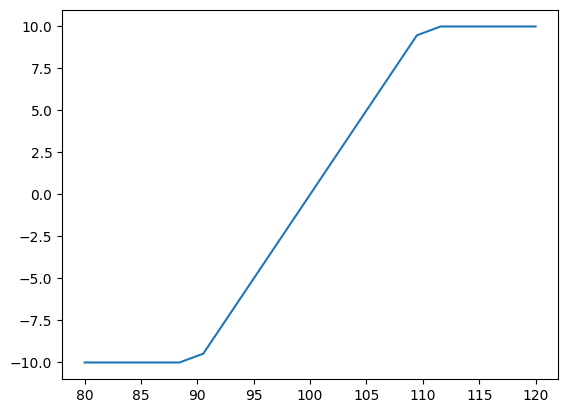

In [ ]:
width = 10
strike =100
def collar_pay_fn(inputs):
    [s] = inputs

    ret = np.maximum(-width, s - strike)
    ret = np.minimum(width, ret)

    return [ret]

s_vec = np.linspace(80, 120, 20)
pay = collar_pay_fn([s_vec])
plt.plot(s_vec, pay[0])

In [ ]:
print("Collars")
df = pd.DataFrame(columns=["Maturity", "Model", "Price"])
for m in [1, 2, 3, 6, 12]:
    contract = collar_timetable(100, 10, mns[m])

    heston_price, _ = heston_model.price(contract, heston_dataset)
    bs_price, _ = lv_model.price(contract, lv_dataset)

    df.loc[len(df)] = [mns[m], "BS", bs_price]
    df.loc[len(df)] = [mns[m], "Heston", heston_price]

df.pivot(columns="Maturity", index=["Model"], values="Price")

Collars


Maturity,2024-01-31,2024-02-29,2024-03-31,2024-06-30,2024-12-31
Model,,,,,
BS,0.29,0.77,1.16,1.21,0.77
Heston,0.29,0.73,1.02,1.15,0.82


Collars are priced very similar. This is not surprising, as a collar can be expressed as a combination of vanillas. We now try the forwad starting version of a collar. 

## Forward Collars
In a forward collar the payoff is given by $\min(\max(S-K, floor), cap)$, however the strike $K$ is set on a future strike fixing date. The qablet_contracts package does not have a class for forward collars either, so we modify what we did earlier.

In [ ]:
# Create a Collar
def fwd_collar_timetable(strike_rate, width, strike_time, maturity):
    events = [
        {
            "track": None,
            "time": strike_time,
            "op": None,
            "quantity": 0,
            "unit": "FIX",  # set the strike
        },
        {
            "track": "",
            "time": maturity,
            "op": "+",
            "quantity": 1,
            "unit": "COLLAR",
        },
    ]

    # Define the strike phrase, return the spot itself.
    def strike_fn(inputs):
        [s] = inputs

        return [s * strike_rate]

    # Define collar phrase.
    def collar_pay_fn(inputs):
        [s, k] = inputs

        ret = np.maximum(-width, s - k)
        ret = np.minimum(width, ret)

        return [ret]

    events_table = pa.RecordBatch.from_pylist(events, schema=TS_EVENT_SCHEMA)
    return {
        "events": events_table,
        "expressions": {
            "COLLAR": {
                "type": "phrase",
                "inp": [ticker, "K"],
                "fn": collar_pay_fn,
            },
            "FIX": {
                "type": "snapper",
                "inp": [ticker],
                "fn": strike_fn,
                "out": ["K"],
            },
        },
    }


timetable = fwd_collar_timetable(1.0, 10, mns[11], mns[12])
print(timetable["events"].to_pandas())
price, _ = heston_model.price(timetable, heston_dataset)
print("\n Price:", price)

  track                      time   op  quantity    unit
0   NaN 2024-11-30 00:00:00+00:00  NaN      0.00     FIX
1       2024-12-31 00:00:00+00:00    +      1.00  COLLAR

 Price: 0.2384333063050488


In [ ]:
print("Collars")
df = pd.DataFrame(columns=["Maturity", "Model", "Price"])
for m in [1, 2, 3, 6, 12]:
    # collars where strikes is set the month before expiration
    contract = fwd_collar_timetable(1.0, 10, mns[m - 1], mns[m])

    heston_price, _ = heston_model.price(contract, heston_dataset)
    bs_price, _ = lv_model.price(contract, lv_dataset)

    df.loc[len(df)] = [mns[m], "BS", bs_price]
    df.loc[len(df)] = [mns[m], "Heston", heston_price]

df.pivot(columns="Maturity", index=["Model"], values="Price")


Collars


Maturity,2024-01-31,2024-02-29,2024-03-31,2024-06-30,2024-12-31
Model,,,,,
BS,0.29,0.14,0.10,0.00,-0.03
Heston,0.29,0.23,0.23,0.21,0.24


We see above that the forward collar prices diverge a lot when the strike is set later in future.

## Cliquet

In a Cliquet the payoff depends on the asset price on
several fixing dates 

$$
T_0 < T_1 < ... T_N
$$

If the returns are given by

$$
r_i = \frac{S_{T_{i+1}}-S_{T_i}}{S_{T_i}}
$$

Then you apply caps and floors to the return.

$$
r^*_i = \max(\min(r_i, cap_L), floor_L)
$$

Then contract has a single payoff at $T_N$, given by

$$
\max \left( floor_G, \sum_0^{N-1} r^*_i \right)
$$

Thus a Cliquet is similar to a series of forward collars. It is a common hedge for firms selling variable annuties.

In [ ]:
global_floor = 0
local_floor = -0.01
local_cap = 0.01
contract = Accumulator(
    "USD", ticker, mns, global_floor, local_floor, local_cap
).timetable()
heston_price, heston_stats = heston_model.price(contract, heston_dataset)
bs_price, bs_stats = lv_model.price(contract, lv_dataset)

# Print the two prices
print("BS Price:", bs_price)
print("HE Price:", heston_price)
print(contract["events"].to_pandas())